In [ ]:
from typing import Tuple
import pandas as pd
from tqdm import tqdm
import os
import time
import random
import pickle
import numpy as np
from os.path import isfile, join
from pydub import AudioSegment
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import librosa

import torch
from torch import nn
from torchaudio import transforms

from models.audio_LSTMCNN import AudioLSTMCNN
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Constants

In [ ]:
RATE = 44100
MEL_SPECTROGRAM_BUCKETS = 128
MEL_SPECTROGRAM_WINDOW_LENGTH = 224
SPECTROS_PER_SECOND = RATE // (MEL_SPECTROGRAM_WINDOW_LENGTH / 2) - 1
CHUNKS_PER_SECOND = 2
CHUNK_SIZE_IN_SPECTROS = int(SPECTROS_PER_SECOND // CHUNKS_PER_SECOND)

TRAINSET_RATIO = 0.8

In [ ]:
def get_quadrant(val: float, aro: float) -> int:
    if val >= 0.5 and aro >= 0.5:
        return 1
    if val >= 0.5 and aro < 0.5:
        return 2
    if val < 0.5 and aro < 0.5:
        return 3
    if val < 0.5 and aro >= 0.5:
        return 4

<hr>

# Dataset

## Create dataset

#### Load data

In [ ]:
AUDIO_FOLDER = "C:\\Users\\amity\\PycharmProjects\\aimpathy\\data\\PMEmo\\PMEmo2019\\chorus"
THAYER_ANOTATIONS_CSV = "C:\\Users\\amity\\PycharmProjects\\aimpathy\\data\\PMEmo\\PMEmo2019\\annotations\\dynamic_annotations.csv"
thayer_annotations_df = pd.read_csv(THAYER_ANOTATIONS_CSV)

In [ ]:
audio_files = [f for f in os.listdir(AUDIO_FOLDER) if isfile(join(AUDIO_FOLDER, f))]
audio_data = dict()
torch_spectorgrams = dict()
spectrogrammer = transforms.MelSpectrogram(sample_rate=RATE, n_fft=(MEL_SPECTROGRAM_BUCKETS * 2 - 2), win_length=MEL_SPECTROGRAM_WINDOW_LENGTH, power=2, normalized=True)

#### Convert to Spectrograms

In [ ]:
spectrograms = dict()
for audio_file in tqdm(audio_files, total=len(audio_files)):
    sound = AudioSegment.from_mp3(os.sep.join([AUDIO_FOLDER, audio_file])).set_channels(1)
    audio_file_wave = sound.export(format="wav", bitrate=RATE)
    sample_rate, samples = wavfile.read(audio_file_wave)
    spectogram = spectrogrammer(torch.from_numpy(samples/(2**15)).float().reshape((1, -1)))
    spectrograms[audio_file] = spectogram
    audio_file_wave.close()
spectrograms = {key: value for key, value in spectrograms.items() if ".wav" not in key}

#### Create final dataset

In [ ]:
dataset = dict()  # music_id: spectrogram, (valence, arousal)
for file_name, spectrogram in tqdm(spectrograms.items(), total=len(spectrograms)):
    music_id = int(file_name.replace(".mp3", ""))
    dataset[music_id] = list()
    max_frame_time = thayer_annotations_df[thayer_annotations_df["musicId"] == music_id]["frameTime"].max()
    if np.isnan(max_frame_time):    
        dataset.pop(music_id)
        continue
    for i in range(int(CHUNKS_PER_SECOND * max_frame_time)):
        data_df = thayer_annotations_df[(thayer_annotations_df["musicId"] == music_id) & (thayer_annotations_df["frameTime"] == i/2)]
        if data_df.empty:
            #  print(f"Skipping {musicI_id} - {i/2}")
            continue
        valence = data_df.iloc[0]["Valence(mean)"]
        arousal = data_df.iloc[0]["Arousal(mean)"]
        dataset[music_id].append((spectrogram[0, :, int((i/2-1)*CHUNK_SIZE_IN_SPECTROS): int((i/2)*CHUNK_SIZE_IN_SPECTROS)], (valence, arousal)))
    
    if len(dataset[music_id]) <= 0:
        dataset.pop(music_id)
        
music_id_to_quadrant = {key: get_quadrant(np.mean([val[1][0] for val in value]), np.mean([val[1][1] for val in value])) for key, value in dataset.items() if value}
quadrant_counters = [list(music_id_to_quadrant.values()).count(i+1) for i in range(4)]
quadrant_ratios = max(quadrant_counters)//np.array(quadrant_counters)

### Divide to train and test

In [ ]:
train_music_ids = random.sample(dataset.keys(), int(TRAINSET_RATIO*len(dataset)))
trainset = {key: value for key, value in dataset.items() if key in train_music_ids}
testset = {key: value for key, value in dataset.items() if key not in train_music_ids}

In [ ]:
with open(f'data/datasets/trainset_{int(time.time())}.pk', 'wb') as f:
    pickle.dump(list(trainset.keys()), f)
with open(f'data/datasets/testset_{int(time.time())}.pk', 'wb') as f:
    pickle.dump(list(testset.keys()), f)

### Load train and test

In [ ]:
dataset_label = '1674741184'
with open(f'data/datasets/trainset_{dataset_label}.pk', 'rb') as f:
    trainset_ids = pickle.load(f)
    trainset = {key: value for key, value in dataset.items() if key in trainset_ids}
with open(f'data/datasets/testset_{dataset_label}.pk', 'rb') as f:
    testset_ids = pickle.load(f)
    testset = {key: value for key, value in dataset.items() if key in testset_ids}

In [ ]:
trainset_quadrant_to_keys = dict()

for music_id in trainset.keys():
    quad = music_id_to_quadrant[music_id]
    if quad not in trainset_quadrant_to_keys:
        trainset_quadrant_to_keys[quad] = list()
    trainset_quadrant_to_keys[quad].append(music_id)

## Plot spectrogram

In [ ]:
import matplotlib.pyplot as plt
import librosa

In [190]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None, ymax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    if ymax:
        axs.set_ylim((0, ymax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [ ]:
plot_spectrogram(dataset[1000][0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

# Model

### Load model

In [ ]:
model_name = f'saved_models/AudioLSTMCNN_1675247749_011615362090984925.pt'
model_c = AudioLSTMCNN()
model_c.load_state_dict(torch.load(model_name));
model_c.eval().cuda()
print("Loaded model")

### Train model

In [213]:
model_c = AudioLSTMCNN().cuda()

In [214]:
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(model_c.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, factor=0.5)

In [216]:
start_time = time.time()
EPOCS = 50
PRINT_MARK = 500
BATCH_SIZE = 50
STOP_LOSS = 0.000025
MIN_LEARNING_RATE = 0.0005


model_c.train()
for epoc in range(EPOCS):
    losses = list()
    quadrants = list()
    real_quadrants = list()
    # model_c.hidden = (model_c.hidden[0].cuda(), model_c.hidden[1].cuda())
    train_key_sample = [key for keys in [random.sample(trainset_quadrant_to_keys[i+1], BATCH_SIZE//4) for i in range(4)] for key in keys]
    random.shuffle(train_key_sample)
    train_sample = [datum for sample_key in train_key_sample for datum in trainset[sample_key]]
    
    for batch_i, (X_train, (valence, arousal)) in enumerate(train_sample):
        optimizer.zero_grad()
        model_c.hidden = (torch.zeros(model_c.hidden[0].shape).cuda(),
                          torch.zeros(model_c.hidden[0].shape).cuda())
        
        y_train = torch.Tensor((valence, arousal)).cuda()
        # Apply the model
        y_pred = model_c(X_train.cuda())  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)

        # Update parameters
        loss.backward(retain_graph=True)
        optimizer.step()

        losses.append(loss.cpu().item())
        real_quadrants.append(get_quadrant(y_train[0].item(), y_train[1].item()))
        quadrants.append(get_quadrant(y_pred[0].item(), y_pred[1].item()))
        
        # Print interim results
        if (batch_i > 0 or epoc == 0) and batch_i%PRINT_MARK == 0:
            print(f'{epoc:2}-{batch_i:4} | loss: {np.mean(losses):.5f}  |  [{quadrants.count(1):4}({real_quadrants.count(1):4}), {quadrants.count(2):4}({real_quadrants.count(2):4}), {quadrants.count(3):4}({real_quadrants.count(3):4}), {quadrants.count(4):4}({real_quadrants.count(4):4})]     lr: {optimizer.param_groups[0]["lr"]}')
    
    scheduler.step(np.mean(losses))

    if np.mean(losses) < STOP_LOSS or optimizer.param_groups[0]["lr"] < MIN_LEARNING_RATE:
        break
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

 0-   0 | loss: 0.21751  |  [   0(   0),    0(   0),    1(   1),    0(   0)]     lr: 0.0001
 0- 500 | loss: 0.02628  |  [  71(  25),   42(  80),  206( 144),  182( 252)]     lr: 0.0001
 0-1000 | loss: 0.02311  |  [ 279( 268),  133( 159),  350( 231),  239( 343)]     lr: 0.0001
 0-1500 | loss: 0.02109  |  [ 475( 458),  162( 204),  548( 326),  316( 513)]     lr: 0.0001
 0-2000 | loss: 0.01905  |  [ 582( 548),  297( 426),  715( 376),  407( 651)]     lr: 0.0001

Duration: 23 seconds


In [217]:
latest_model_name = f'saved_models/AudioLSTMCNN_{int(time.time())}_{str(np.mean(losses))[2:]}.pt'
torch.save(model_c.state_dict(), latest_model_name)
print(f"Saved model {latest_model_name}")

Saved model saved_models/AudioLSTMCNN_1675255903_018411057069375382.pt


### Test model

In [200]:
losses = list()
quadrants = list()

model_c.eval().cuda()
with torch.no_grad():
    model_c.hidden = (model_c.hidden[0].cuda(), model_c.hidden[1].cuda())
    test_sample = [datum for key, value in testset.items() for datum in value]
    for batch_i, (X_test, (valence, arousal)) in tqdm(enumerate(test_sample), total=len(test_sample)):
        y_test = torch.Tensor((valence, arousal)).cuda()
        # Apply the model
#         model_c.hidden = (torch.zeros(model_c.hidden[0].shape).cuda(),
#                           torch.zeros(model_c.hidden[0].shape).cuda())
        
        y_val = model_c(X_test.cuda())
        loss = criterion(y_val, y_test)
        losses.append(loss.cpu())
        quadrants.append((get_quadrant(y_val[0].item(), y_val[1].item()), get_quadrant(y_test[0].item(), y_test[1].item())))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 7430/7430 [00:24<00:00, 297.63it/s]


In [201]:
print(f"Mean: {np.mean(losses):.5f}, median: {np.median(losses):.5f}")

Mean: 0.14048, median: 0.11059


In [202]:
print(confusion_matrix([a[0] for a in quadrants], [a[1] for a in quadrants]))
print("\n")
print(classification_report([a[0] for a in quadrants], [a[1] for a in quadrants]))

[[5045  544 1248  593]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]


              precision    recall  f1-score   support

           1       1.00      0.68      0.81      7430
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.68      7430
   macro avg       0.25      0.17      0.20      7430
weighted avg       1.00      0.68      0.81      7430



C:\Users\amity\Anaconda3\envs\aimpathy\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amity\Anaconda3\envs\aimpathy\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\amity\Anaconda3\envs\aimpathy\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Inspect quadrants

In [ ]:
testset.keys()

In [ ]:
test_index = 519
test_location = 0

with torch.no_grad():
    pred = model_c(testset[test_index][test_location][0].cuda()).cpu()
print(pred)
print([denormalize(a.item()) for a in pred])
print(testset[test_index][test_location][1])

In [ ]:
[(key, value[0][1]) for key, value in testset.items() if value and value[0][1] < (0.5, 0.5)]

## Random results classifier

#### Random vs. testset

In [203]:
losses = list()

test_sample = [datum for key, value in testset.items() for datum in value]
for batch_i, (X_test, (valence, arousal)) in tqdm(enumerate(test_sample), total=len(test_sample)):
    y_test = torch.Tensor((valence, arousal)).cuda()
    y_val = torch.Tensor((random.random(), random.random())).cuda()
    loss = criterion(y_val, y_test)
    losses.append(loss.cpu())

100%|███████████████████████████████████████████████████████████████████████████████████████████| 7430/7430 [00:01<00:00, 3920.18it/s]


In [204]:
print(f"Mean: {np.mean(losses):.5f}, median: {np.median(losses):.5f}")

Mean: 0.12753, median: 0.09907


#### Random vs. Random

In [ ]:
losses = list()

test_sample = [datum for key, value in testset.items() for datum in value]
for batch_i, (X_test, (valence, arousal)) in tqdm(enumerate(test_sample), total=len(test_sample)):
    y_test = torch.Tensor((random.random(), random.random())).cuda()
    y_val = torch.Tensor((random.random(), random.random())).cuda()
    loss = criterion(y_val, y_test)
    losses.append(loss.cpu())

In [ ]:
print(f"Mean: {np.mean(losses):.5f}, median: {np.median(losses):.5f}")

<hr>

# Research machine factors

In [205]:
def get_spectograms(file_name: str):
    sample_rate, samples = wavfile.read(os.sep.join(["data", "test_audio", file_name]))
    spectrogram = spectrogrammer(torch.from_numpy(samples/(2**15)).float().reshape((1, -1)))
    audio_file_wave.close()
    chunked_spectograms = [spectrogram[0, :, int((i/2-1)*CHUNK_SIZE_IN_SPECTROS): int((i/2)*CHUNK_SIZE_IN_SPECTROS)] for i in range(spectogram.shape[2]//CHUNK_SIZE_IN_SPECTROS)]
    return chunked_spectograms

In [206]:
def test_spectrograms(spetrograms_to_test):
    valence_values = list()
    arousal_values = list()

    with torch.no_grad():
        model_c.hidden = (model_c.hidden[0].cuda(), model_c.hidden[1].cuda())
        for ind, X_test in tqdm(enumerate(spetrograms_to_test), total=len(spetrograms_to_test)):
            if X_test.shape[1] < CHUNK_SIZE_IN_SPECTROS:
                continue
            model_c.hidden = (torch.zeros(model_c.hidden[0].shape).cuda(),
                              torch.zeros(model_c.hidden[0].shape).cuda())
            y_val = model_c(X_test.cuda())
            valence_values.append(y_val[0].item())
            arousal_values.append(y_val[1].item())
    
    return valence_values, arousal_values

In [207]:
def plot_thayer_model(valence_values, arousal_values):
    x_values = list(range(len(valence_values)))
    fig, axes = plt.subplot_mosaic("AB", figsize=(20, 5))
    ax_valence, ax_arousal = axes.values()
    ax_valence.set_title('Valence - decending chromatic scale')
    ax_valence.set_xlabel('Time [sec]')
    ax_valence.set_ylabel('Valence')
    valence_line, = ax_valence.plot(x_values, valence_values, '-', lw=1)

    ax_arousal.set_title('Arousal - decending chromatic scale')
    ax_arousal.set_xlabel('Time [sec]')
    ax_arousal.set_ylabel('Arousal')
    arousal_line, = ax_arousal.plot(x_values, arousal_values, '-', lw=1)

In [208]:
model_c.eval().cuda()
print("In EVAL mode")

In EVAL mode


#### Chromatic scale down

In [209]:
chromatic_scale_down_spectograms = get_spectograms("chromatic_scale_down.wav")

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 124.70it/s]


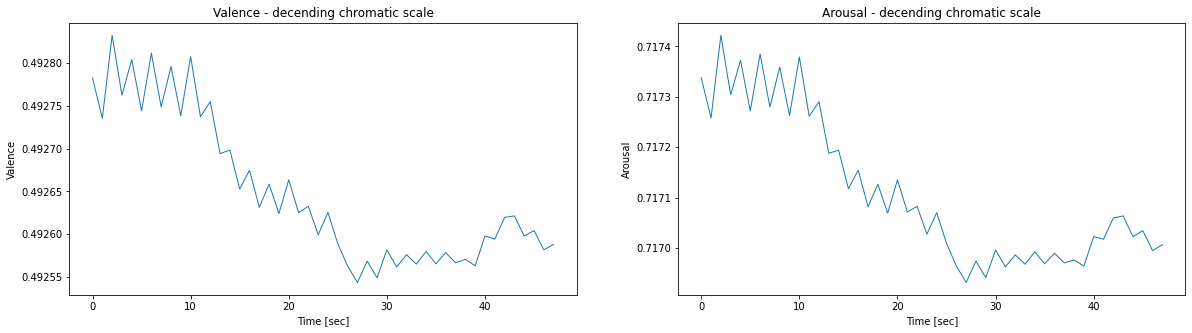

In [210]:
valence_values, arousal_values = test_spectrograms(chromatic_scale_down_spectograms)
plot_thayer_model(valence_values, arousal_values)

#### One tone A

In [211]:
one_tone_A_spectograms = get_spectograms("one_tone_A.wav")

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 132.97it/s]


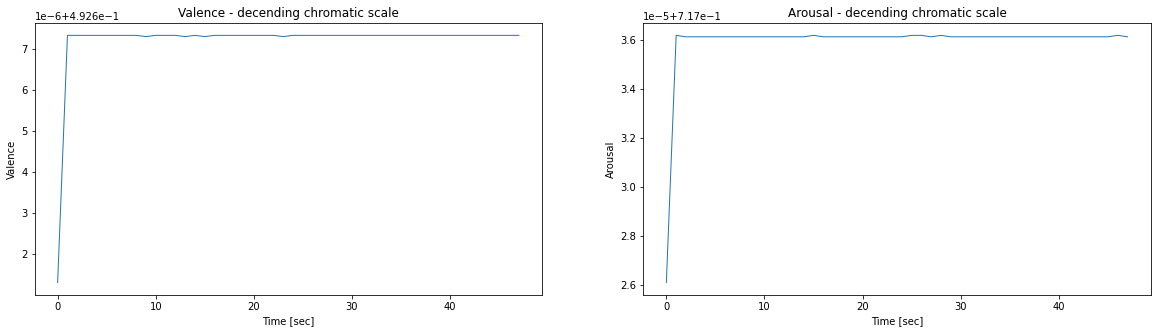

In [212]:
valence_values, arousal_values = test_spectrograms(one_tone_A_spectograms)
plot_thayer_model(valence_values, arousal_values)